<a href="https://www.kaggle.com/code/habibulbasher01644/olive-leaf-image-classification?scriptVersionId=222970603" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/olive-leaf-image-dataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import all necessary library

In [65]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import collections 
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adagrad, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Approch:1 Custom CNN model without data augmentation

## 1. Define Dataset Paths

In [66]:
train_dir = '/kaggle/input/olive-leaf-image-dataset/dataset/train'
test_dir = '/kaggle/input/olive-leaf-image-dataset/dataset/test'
batch_size = 32
img_size = (224, 224)

## 2. Load Dataset Without Data Augmentation

In [67]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                          train_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical',
                          shuffle=True)
test_generator = test_datagen.flow_from_directory(
                          test_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical', 
                          shuffle=False)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 3.dataset summary

In [68]:
# Print dataset summary
print(f"Found {train_generator.samples} images belonging to {len(train_generator.class_indices)} classes in the training set.")
print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes in the testing set.")
print(f"Class Labels: {train_generator.class_indices}")

# Function to count images per class
def count_images_per_class(directory, class_indices):
    class_counts = Counter()
    for class_name, class_index in class_indices.items():
        class_path = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_path)) if os.path.exists(class_path) else 0
    return class_counts

# Get per-class image counts
train_class_counts = count_images_per_class(train_dir, train_generator.class_indices)
test_class_counts = count_images_per_class(test_dir, test_generator.class_indices)

# Print per-class distribution
print("\nTraining Data:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")

print("\nTesting Data:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} images")

Found 2720 images belonging to 3 classes in the training set.
Found 680 images belonging to 3 classes in the testing set.
Class Labels: {'Healthy': 0, 'aculus_olearius': 1, 'olive_peacock_spot': 2}

Training Data:
Healthy: 830 images
aculus_olearius: 690 images
olive_peacock_spot: 1200 images

Testing Data:
Healthy: 220 images
aculus_olearius: 200 images
olive_peacock_spot: 260 images


## 4.Define Custom CNN Model

In [69]:
def build_custom_cnn():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Batch Normalization only in Block 1
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 3
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 4
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 5
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))  # Dropout to reduce overfitting
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    return model

custom_cnn_model = build_custom_cnn()
custom_cnn_model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_330 (Conv2D)                  │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_331 (Conv2D)                  │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_332 (Conv2D)                  │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_150 (MaxPooling2D)     │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_333 (Conv2D)                  │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_334 (Conv2D)                  │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_151 (MaxPooling2D)     │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_335 (Conv2D)                  │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_336 (Conv2D)                  │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_152 (MaxPooling2D)     │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_337 (Conv2D)                  │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_338 (Conv2D)                  │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_153 (MaxPooling2D)     │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_339 (Conv2D)                  │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_340 (Conv2D)                  │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_154 (MaxPooling2D)     │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_30 (Flatten)                 │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 1000)                │      12,545,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 1000)                │       1,001,0

 Total params: 14,730,155 (56.19 MB)

 Trainable params: 14,730,123 (56.19 MB)

 Non-trainable params: 32 (128.00 B)

## 5.Train and Evaluate Model

In [70]:
optimizer = Adam(learning_rate=0.0001)

accuracy_history = []
loss_history = []
test_accuracy_history = []

def train_and_evaluate(model):
    print(f"🔹 Training Model using Adam optimizer...")

    # Compile Model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train Model
    history = model.fit(train_generator, validation_data=test_generator, epochs=20, batch_size=batch_size)

    # Store accuracy and loss values for each epoch
    accuracy_history.append(history.history['val_accuracy'])
    loss_history.append(history.history['val_loss'])

    # Evaluate Model
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_true = test_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    # Test Accuracy Calculation
    test_accuracy = np.sum(y_pred == y_true) / len(y_true)
    test_accuracy_history.append(test_accuracy)

    print(f"\n🔹 Classification Report for Adam:")
    print(classification_report(y_true, y_pred))

    print("\n🔹 Confusion Matrix:")
    print(cm)
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())

    # Labels, title and ticks
    plt.title('Confusion Matrix for Model Evaluation')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    print(f"\n🔹 Test Accuracy for Adam: {test_accuracy:.4f}")

    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Adam - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Adam - Loss')

    plt.show()


## 6.Train and evaluate with Adam optimizer

🔹 Training Model using Adam optimizer...
Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.5042 - loss: 0.9593 - val_accuracy: 0.3294 - val_loss: 1.1244
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.7274 - loss: 0.6038 - val_accuracy: 0.5382 - val_loss: 0.9867
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.7865 - loss: 0.4973 - val_accuracy: 0.5926 - val_loss: 0.9587
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.8134 - loss: 0.4586 - val_accuracy: 0.6294 - val_loss: 0.8185
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.8482 - loss: 0.3969 - val_accuracy: 0.6485 - val_loss: 0.8284
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.8469 - loss: 0.3606 - val_accuracy: 0.6912 - val_loss: 0.7023
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.8753 - loss: 0.3209 - val_accuracy: 0.7515 - val_loss: 0.5753
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - a

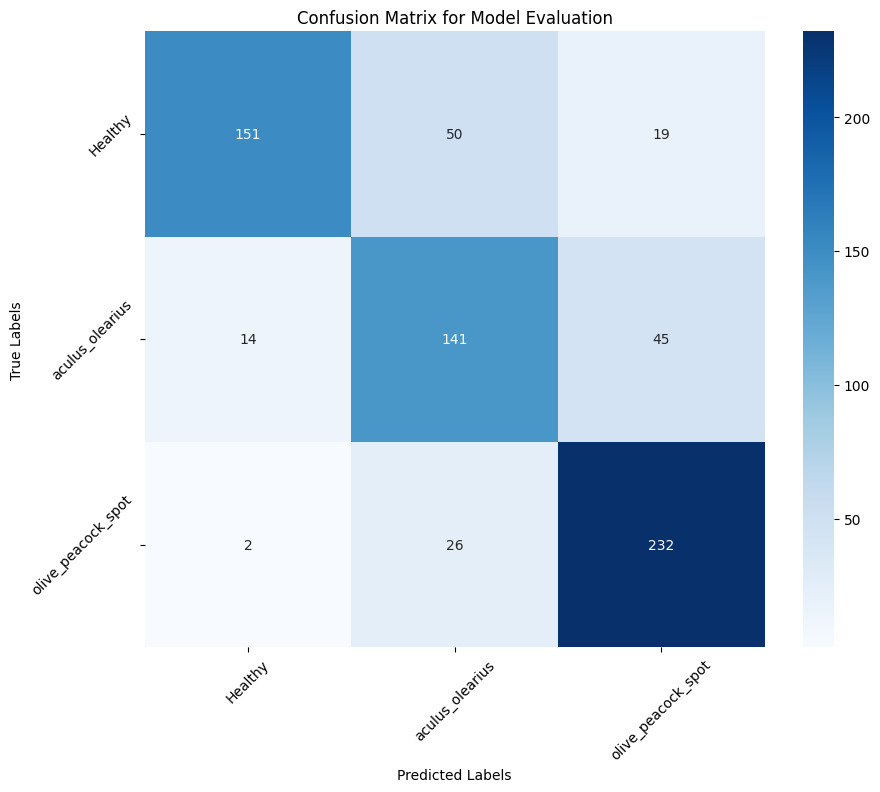

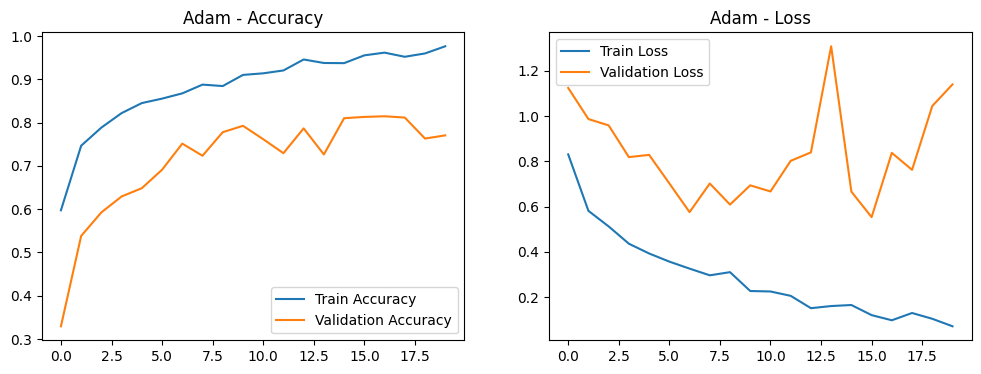

In [71]:
model = build_custom_cnn()

# Train and evaluate with Adam optimizer
train_and_evaluate(model)


## 7.After training all models, plot heatmap for accuracy and loss

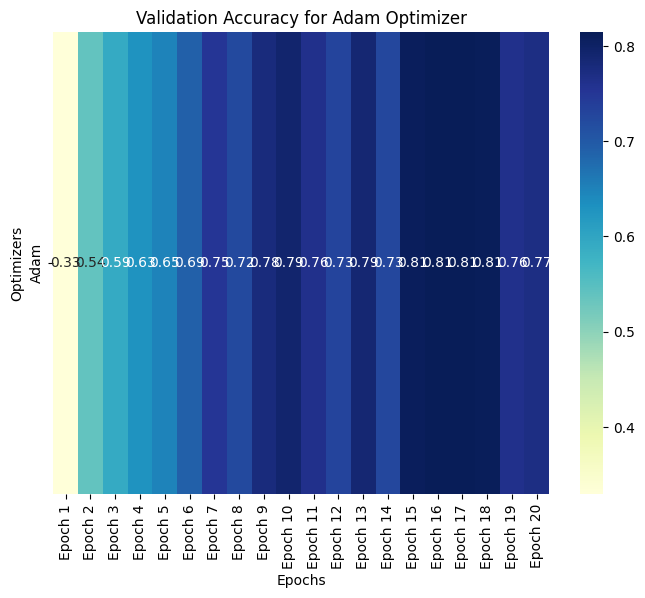

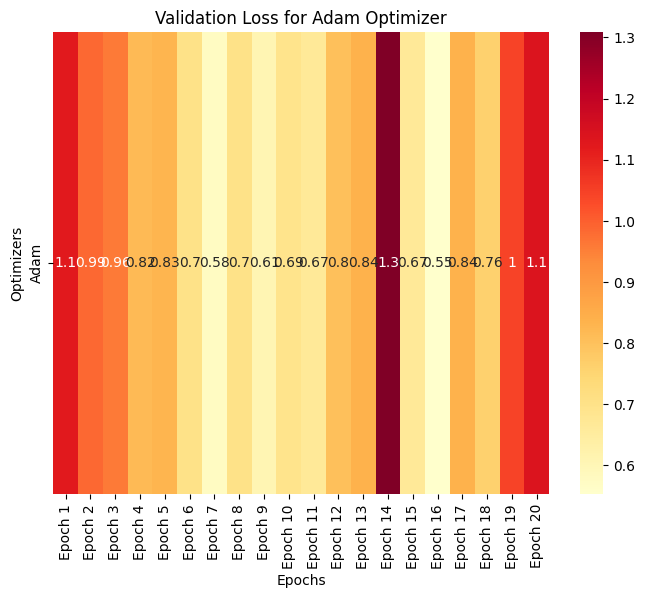

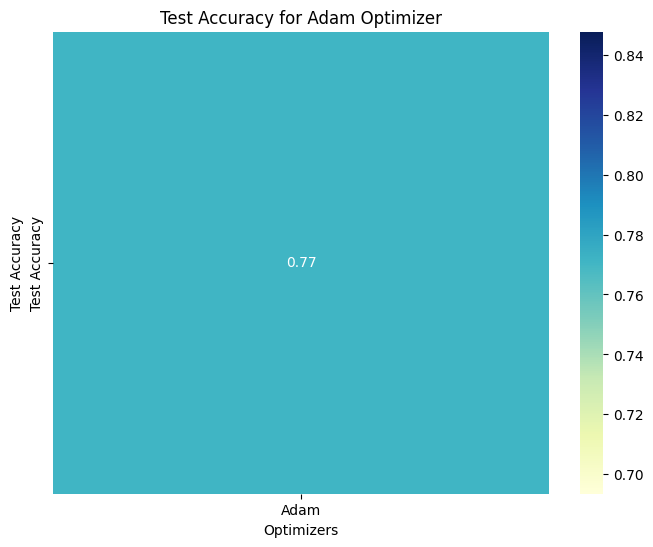

In [72]:
# Heatmap for Validation Accuracy
accuracy_array = np.array([accuracy_history[0]])
plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_array.reshape(1, -1), annot=True, cmap="YlGnBu", xticklabels=[f"Epoch {i+1}" for i in range(20)], yticklabels=['Adam'])
plt.title('Validation Accuracy for Adam Optimizer')
plt.ylabel('Optimizers')
plt.xlabel('Epochs')
plt.show()

# Heatmap for Validation Loss
loss_array = np.array([loss_history[0]])
plt.figure(figsize=(8, 6))
sns.heatmap(loss_array.reshape(1, -1), annot=True, cmap="YlOrRd", xticklabels=[f"Epoch {i+1}" for i in range(20)], yticklabels=['Adam'])
plt.title('Validation Loss for Adam Optimizer')
plt.ylabel('Optimizers')
plt.xlabel('Epochs')
plt.show()

# Plot Test Accuracy for Adam optimizer
test_accuracy_array = np.array([test_accuracy_history[0]])
plt.figure(figsize=(8, 6))
sns.heatmap(test_accuracy_array.reshape(1, -1), annot=True, cmap="YlGnBu", xticklabels=['Adam'], yticklabels=["Test Accuracy"])
plt.title('Test Accuracy for Adam Optimizer')
plt.ylabel('Test Accuracy')
plt.xlabel('Optimizers')
plt.show()

# Approch:2 Custom CNN model with data augmentation

In [80]:
optimizer1 = Adam(learning_rate=0.0001)

# Create dictionaries to store accuracy, loss, and test accuracy values for Adam optimizer
accuracy_history1 = []
loss_history1 = []
test_accuracy_history1 = []

## 1.Data Augmentation

In [81]:
train_datagen1 = ImageDataGenerator(
    rescale=1./255,  # Rescale image pixel values to [0, 1]
    rotation_range=60,  # Random rotations between -30 to 30 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Shear transformation
    zoom_range= 0.4, # Random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels after transformations
)

test_datagen1= ImageDataGenerator(rescale=1./255)


## 2.Load Dataset With Data Augmentation

In [82]:
train_generator1= train_datagen1.flow_from_directory(
                          train_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical',
                          shuffle=True)
test_generator1= test_datagen1.flow_from_directory(
                          test_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical', 
                          shuffle=False)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 2.Train and Evaluating Model

🔹 Training Model using Adam optimizer with Data Augmentation...
Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 407ms/step - accuracy: 0.5575 - loss: 0.8942 - val_accuracy: 0.3279 - val_loss: 1.1073
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 394ms/step - accuracy: 0.6935 - loss: 0.6589 - val_accuracy: 0.5294 - val_loss: 0.9413
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 402ms/step - accuracy: 0.6996 - loss: 0.6196 - val_accuracy: 0.5765 - val_loss: 0.8319
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 403ms/step - accuracy: 0.7357 - loss: 0.6207 - val_accuracy: 0.6235 - val_loss: 0.8328
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 397ms/step - accuracy: 0.7697 - loss: 0.5318 - val_accuracy: 0.6515 - val_loss: 0.7386
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 402ms/step - accuracy: 0.7945 - loss: 0.5047 - val_accuracy: 0.7206 - val_loss: 0.6834
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.8020 - loss: 0.5093 - val_accuracy: 0.6735 - val_loss: 0.7101
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━

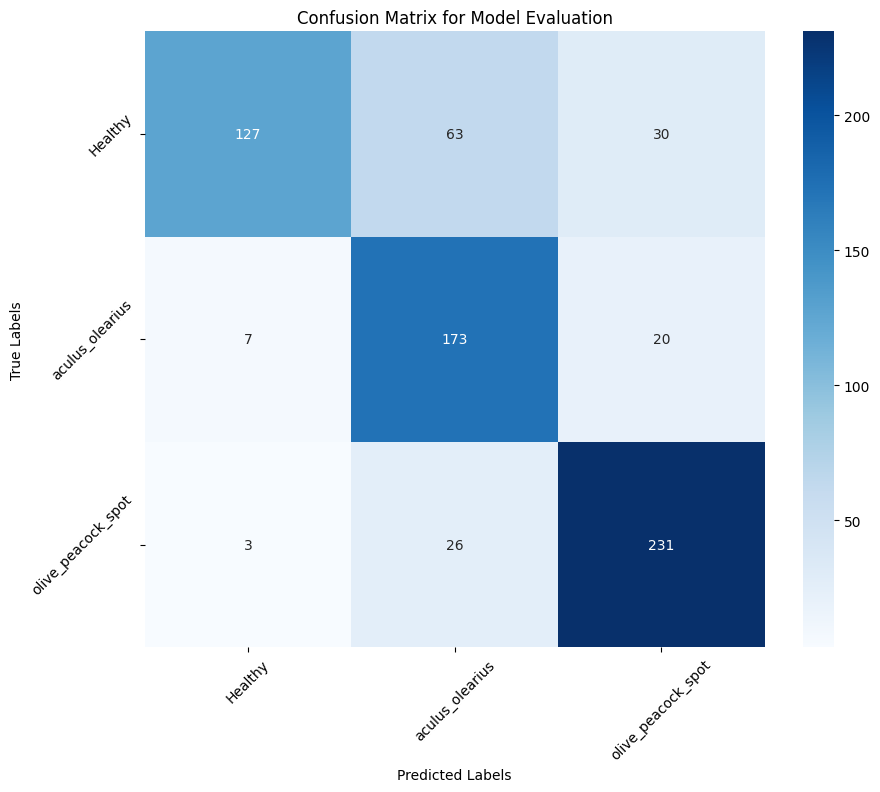

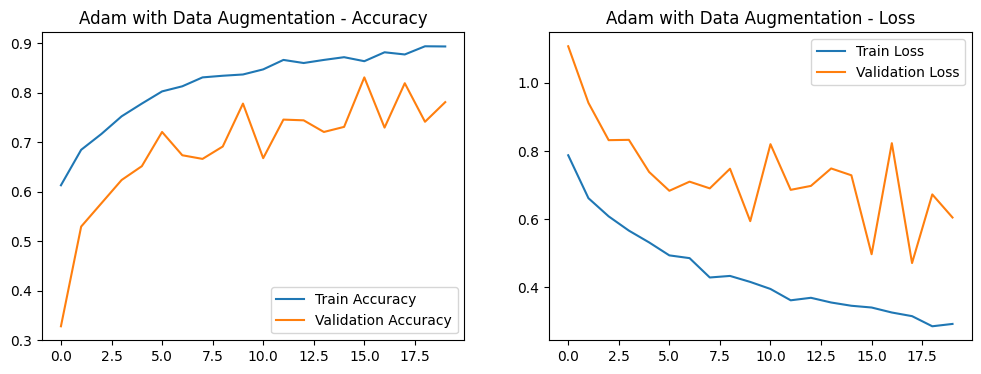

In [83]:
def train_and_evaluate_with_augmentation(model):
    print(f"🔹 Training Model using Adam optimizer with Data Augmentation...")

    # Compile Model
    model.compile(optimizer=optimizer1, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train Model with augmented data
    history1 = model.fit(
        train_generator1,  # Augmented training data
        validation_data=test_generator1,  # Validation data
        epochs=20
    )

    # Store accuracy and loss values for each epoch
    accuracy_history1.append(history1.history['val_accuracy'])
    loss_history1.append(history1.history['val_loss'])

    # Evaluate Model
    y_pred = np.argmax(model.predict(test_generator1), axis=1)
    y_true = test_generator1.classes

    cm = confusion_matrix(y_true, y_pred)
    # Test Accuracy Calculation
    test_accuracy1 = np.sum(y_pred == y_true) / len(y_true)
    test_accuracy_history1.append(test_accuracy1)

    print(f"\n🔹 Classification Report for Adam with Data Augmentation:")
    print(classification_report(y_true, y_pred))

    print("\n🔹 Confusion Matrix:")
    print(cm)
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator1.class_indices.keys(), yticklabels=test_generator1.class_indices.keys())

    # Labels, title and ticks
    plt.title('Confusion Matrix for Model Evaluation')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    print(f"\n🔹 Test Accuracy for Adam with Data Augmentation: {test_accuracy1:.4f}")

    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Train Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Adam with Data Augmentation - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Train Loss')
    plt.plot(history1.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Adam with Data Augmentation - Loss')

    plt.show()

# Build the custom CNN model (make sure to define your model here)
model = build_custom_cnn()

# Train and evaluate with Adam optimizer and data augmentation
train_and_evaluate_with_augmentation(model)


## After training, plot heatmap for accuracy and loss


In [ ]:
accuracy_array = np.array([accuracy_history1[0]])
plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_array.reshape(1, -1), annot=True, cmap="YlGnBu", xticklabels=[f"Epoch {i+1}" for i in range(20)], yticklabels=['Adam with Augmentation'])
plt.title('Validation Accuracy for Adam Optimizer with Data Augmentation')
plt.ylabel('Optimizers')
plt.xlabel('Epochs')
plt.show()

# Heatmap for Validation Loss
loss_array = np.array([loss_history1[0]])
plt.figure(figsize=(8, 6))
sns.heatmap(loss_array.reshape(1, -1), annot=True, cmap="YlOrRd", xticklabels=[f"Epoch {i+1}" for i in range(20)], yticklabels=['Adam with Augmentation'])
plt.title('Validation Loss for Adam Optimizer with Data Augmentation')
plt.ylabel('Optimizers')
plt.xlabel('Epochs')
plt.show()

# Plot Test Accuracy for Adam optimizer with data augmentation
test_accuracy_array = np.array([test_accuracy_history1[0]])
plt.figure(figsize=(8, 6))
sns.heatmap(test_accuracy_array.reshape(1, -1), annot=True, cmap="YlGnBu", xticklabels=['Adam with Augmentation'], yticklabels=["Test Accuracy"])
plt.title('Test Accuracy for Adam Optimizer with Data Augmentation')
plt.ylabel('Test Accuracy')
plt.xlabel('Optimizers')
plt.show()

In [ ]:
print("sakib")

# Approach 2: Using four Pre-trained CNN Model

# Data Augmentation
## ImageDataGenerator
    
* rescale: Makes the image numbers smaller so the computer can understand.(rescale=1./255 - Makes all pixel values between 0 and 1)
* rotation_range: Spins the image around.
* width_shift_range and height_shift_range: Moves the image left/right or up/down.
* shear_range: Tilts the image.
* zoom_range: Zooms in or out.
* horizontal_flip and vertical_flip: Flips the image left/right or upside-down.
* fill_mode: Fills empty spaces when you move or tilt the image.


In [ ]:
train_datagen= ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=[0.5, 1.0],
    brightness_range=[0.2, 1.0],
    horizontal_flip=True,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
)

test_datagen = ImageDataGenerator(rescale=1./255)



# Data Loading

In [ ]:

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32


# Load images from directory
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle = True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle = False
)

# Get class indices
print(train_generator.class_indices)


# Function to Create Model

In [ ]:
def create_model(base_model):

    # Freeze the base model initially
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


#  Base Models Dictionary

#  Training Loop for All Models